<center>
    <h1>Scientific Computing With Python</h1>
    <h2>Project: Tracking muons with Drift Tubes chambers</h2>
    <h3>Duy Tommy Tran, Hanna Falch Naestby, Marit Svendby Otervik & Tone Alsvik Finstad</h3>
</center>

In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
%matplotlib notebook
%matplotlib inline

In [3]:
# Setting the dpi of the figure to 180 dpi
#mpl.rcParams['figure.dpi'] = 180

# Defining some figure parameters
mpl.rcParams.update({'figure.figsize': (10.0, 7),                   # Figuresize
                     'legend.fontsize': 17, 'legend.handlelength': 3, # Legend
                     'xtick.labelsize': 15, 'ytick.labelsize': 15,    # Tick-sizes of the axes
                     'font.size': 15})                                # Fontsize

In [4]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4, -267.4, -261.5,]

# Z coordinates translations
local_z_shifts = [z * ZCELL for z  in range(0, 4)]
global_z_shifts = [823.5, 0., 823.5, 0.]

## Part 1

To process the data and place the hits appropriately in the global xy-plane, the coordinates where transformed from local to global in the dataReader() function. 
The first step was to find the chamber (0-3) and the layer (1-4) for each hit and use the given translation coordinates (global_x_shifts, local_z_shifts and global_z_shifts) to translate the chambers and layers to global coordinates. In addition, we added a x_shift variable to account for the layers in a chamber being staggered by half a cell.

Finally, we assumed that the hits in local coordinates represents the distance from the central wire through each layer, and used the global coordinates of the chamber and layers to place the hits correctly in global coordinates. Xleft and yleft in the data-file are defined as, respectively, the distance from the wire on the left side and right side. However, because of a rotation by 180 degrees of all the detectors, these two parameters were switched when calculating our variables x_left and x_right, to change the orientation.

In [22]:
#Function that reads data from a given event from a txt file, and formats it so we get individual arrays with the coordinates.


def dataReader(filename, n, c = [0, 1, 2, 3]):
  with open(filename, 'r') as file:
    csvreader = csv.reader(file, delimiter = ' ')
    
    for row in csvreader:
      if row[0] == str(n): 
        x_length = 700 #approximate number for width of cells, no other purpose than shifts for plotting

        hits = int(row[1])
        xleft_list=[]
        xright_list=[]
        z_list = []

        calibration_x = []
        calibration_z = []
        
      
        for i in range(hits):
          chamber = int(row[(2 + 5*i)]) #for each hit there is 5 coordinates
          layer = int(row[(3 + 5*i)]) -1
          
          # Takes into account the global and local shifts in the z, and x direction.
          z_coord = global_z_shifts[chamber] + local_z_shifts[layer]

          x_shift = [global_x_shifts[0]-global_x_shifts[1], 0, global_x_shifts[2] - global_x_shifts[3], 0]

          x_left = global_x_shifts[chamber] - (1/2)*x_length  + (-1)**(layer)*(1/4)*XCELL - float(row[(5 + 5*i)]) + x_shift[chamber]
          x_right = global_x_shifts[chamber] - (1/2)*x_length  + (-1)**(layer)*(1/4)*XCELL + float(row[(4 + 5*i)]) + x_shift[chamber]
          
          # Gives the lists of hits in the given chambers
          if chamber in c:
            calibration_x.append([x_left, x_right])
            calibration_z.append(z_coord)

          xleft_list.append(x_left)
          xright_list.append(x_right)
          z_list.append(z_coord)
        
        return xleft_list, xright_list, z_list, calibration_x, calibration_z
    

In [23]:
# Plots the reactangles (detectors)
def create_rectangle(ax, cell):
    for c in cell:
        rect = mpl.patches.Rectangle((global_x_shifts[c]-700, global_z_shifts[c]-0.5*ZCELL), 700, ZCELL*4, linewidth=1, edgecolor='lightgrey', facecolor='none')
        ax.add_patch(rect)

# Plots the hits and detectors
def plotter(x, y, z, cell=[0,1,2,3]):
    fig, ax = plt.subplots()
    ax.scatter(x, z)
    ax.scatter(y, z)
    ax.set_xlim(-1000, 1500)
    ax.set_ylim(-200, 1000)
    
    rect = create_rectangle(ax,cell)
    plt.show()

In [42]:
# Formated data from dataset "Run000260", event 1
xleft_d1, xright_d1, z_d1, cx_d1, cz_d1 = dataReader('./preprocess/Run000260/data_000000.txt', 1, [2,3])

In [43]:
# Formated data from dataset "Run000260", event 2
xleft_d2, xright_d2, z_d2, cx_d2, cz_d2 = dataReader('./preprocess/Run000260/data_000000.txt', 2, [2, 3])

In [44]:
# Formated data from dataset "Run000260", event 1269
xleft_d1269, xright_d1269, z_d1269, cx_d1269, cz_d1269 = dataReader('./preprocess/Run000260/data_000000.txt', 1269, [2,3])

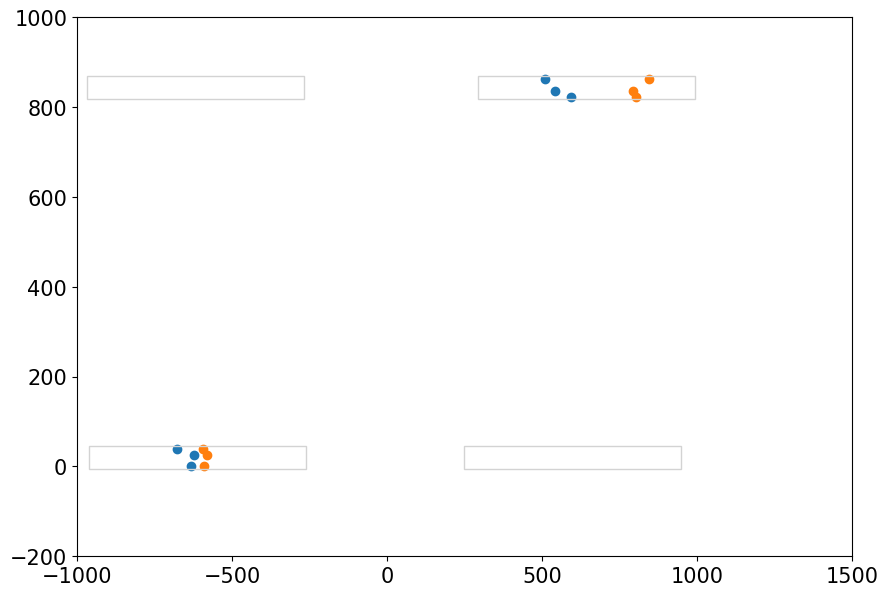

In [25]:
# Plots for event 1
plotter(xleft_d1, xright_d1, z_d1)

## Part 2

In this part we needed to check where the hits in the events where located, and sorted them accordingly. To do this we modified the 'dataReader' function, so that we could send in parameters for which detectors we wanted. If no input was given, the function would default to accept all the detectors. The sorting was done using a simple if-statement.

When we had sorted the hits, we needed to perform a linear fit for a given detector. This was done only for the cases where at least 3 hits in 3 layers of the detector were found. This was done in the function linear_fit(), by using the numpy function polyfit. The function gaveus both the linear solution for the selected hits, and the residuals which allowed us to check the fit of this solution. 
This was important as we needed to repeat the fit for all left/right combinations, and find the best one. This is done in the function 'linear_loop', by iterating through the possible combinations and saving the solution with the lowest residuals. The other solutions were discarded.

The solution is plotted by the function 'part2'.

In [17]:
#function that finds a linear fit for a set of points
def linear_fit(x,z):
    coef, residuals, _, _, _ = np.polyfit(x, z, 1, full=True)  #uses numpy-function polyfit
    f = np.poly1d(coef)
    return f, residuals  #returns the function for the best fit and the residuals (error)

In [18]:
#function that finds the best linear fit for the hits
def linear_loop(x, z):
    min_res=10000000  #a very high number, not of any importance as it will be changed
    x_best=[]
    f_best=0 
    combinations=list(itertools.product(*x))  #creating a list of all possible combinations of hits 
    for combination in combinations:          #iterating through all the combinations
        f, res = linear_fit(combination, z)   #calculating a linear fit for the combination
        if res<min_res:         
            min_res=res          #setting min_res to the smallest residue so far
            x_best=combination   #saving the best combination of hits (with smallest residue)
            f_best=f             #saving the best fit (with smallest residue)
                
    return x_best, f_best


In [32]:
#function that calls the linear loop function and plots the results
def part2(x, z, cell=[0,1,2,3]):
    xx, f = linear_loop(x, z)
    x1 = np.array([-100, -1200])
    
    fig, ax = plt.subplots()

    ax.scatter(xx, z)
    ax.plot(x1 ,f(x1), '-k')
    ax.set_xlim(-1200, 1000)
    ax.set_ylim(-100, 1000)
    
    rect = create_rectangle(ax, cell)
    
    plt.show()

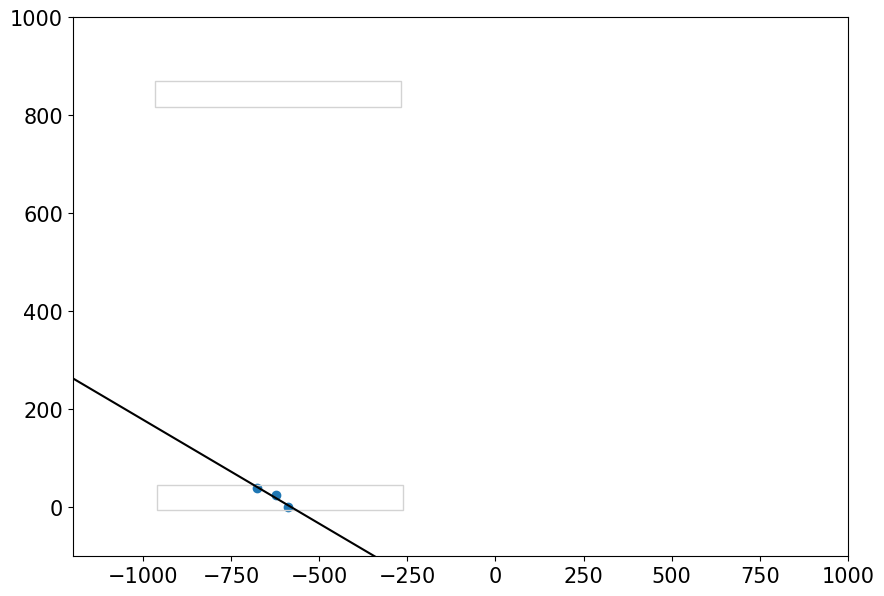

In [45]:
#Plots for event 1, chamber 2
part2(cx_d1, cz_d1, [2,3])

It is clear from the graph that this is a good relative fit, but that the direction of the linear fit is quite off. This makes sense seeing as our code only consideres the realtive error in one detector, and does not consider the hits in the detector across it. 

## Part 3

In this part we have performed a global linear fit by using the hits from the previous point for two detectors. Here we use the same linear loop and linear fit functions that we created in part 2, as we made this so that it could handle however many hits as needed. Here we therefore only perform the same process as in part 2, but we include more points. We have also plotted the global fit for the hits, in the same figure as the global fit for hits in the same chamber to compare. 

In [38]:
# Function that finds best combination for the global fit, and uses this combination for the local fits aswell.
def part3(x, z, cell = [0,1,2,3]):
    xx, f = linear_loop(x, z)
    
    x1 = np.array([-100, -1200])

    x_up = []
    x_down = []
    z_up = []
    z_down = []

    for i in range(len(z)):
        if z[i] > 300:
            x_up.append(xx[i])
            z_up.append(z[i])
        else:
            x_down.append(xx[i])
            z_down.append(z[i])

    f_up, res_up = linear_fit(x_up, z_up)
    f_down, res_down = linear_fit(x_down, z_down)

    fig, ax = plt.subplots()
    ax.scatter(xx, z)
    ax.plot(x1 ,f(x1), '-k')
    ax.plot(x1, f_up(x1))
    ax.plot(x1, f_down(x1))
    ax.set_xlim(-1200, 1000)
    ax.set_ylim(-100, 1000)
    
    rect = create_rectangle(ax, cell)
    plt.show()
    
    
    


[-677.4399999999999, -678.7399999999999, -694.9, -693.5999999999999]
[-590.53, -589.81, -590.75]


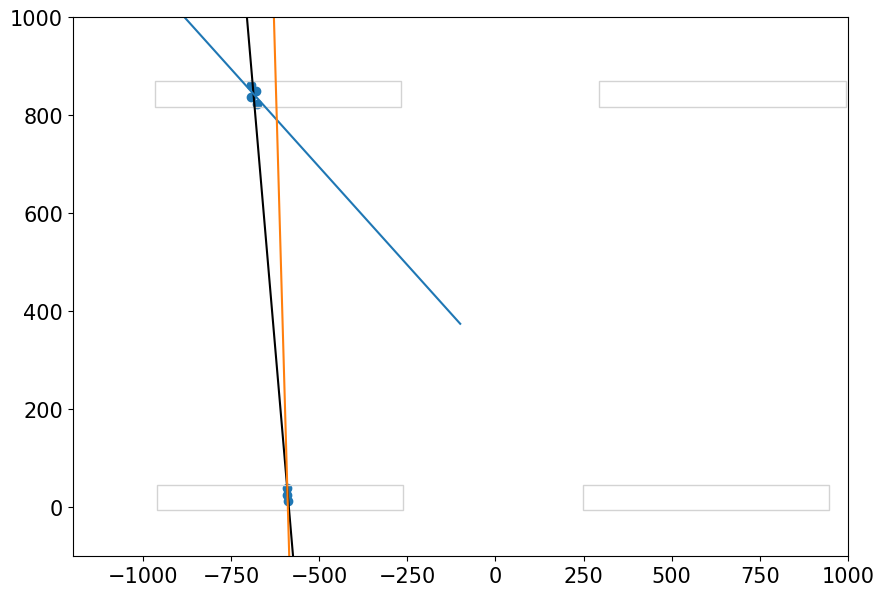

In [41]:
#Plots the local and global fits for event 1269, chambers 2, 3
part3(cx_d1269, cz_d1269)

Here one can see the importance of including the hits in different chambers, as you can see that the linear fit of the points will not be the same locally as globally. The blue and orange lines are local fits for the chosen points used in the global fit (black line). Even though we have the same points, the resulting lines can become very different, as we see for the blue line, while the orange line seems to fit quite well with the global fit. The local fits here are also closer to the global fit as they use the same points as the global fit, but in part 2 we found the best combination of points for the local fit. 